In [25]:
from optimization_func import simulated_annealing
from helper import mse, lotka_volterra, int_cost_lotka_volterra, get_predator_prey_data
import multiprocessing as mp
from workers import vary_T_worker, vary_sigma_worker
t, P = get_predator_prey_data()
import shelve
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
from scipy import stats

In [12]:
mpl.rcParams["figure.dpi"] = 180
mpl.rcParams["legend.fontsize"] = 11
plt.rc("text", usetex=True)
plt.rc("text.latex", preamble=r"""
\usepackage{palatino}
\usepackage{newpxmath}""")
plt.rc("font", family="serif")

In [13]:
def sp_confidence_interval(samples, p=0.95):
    """ Calculates the confidence interval (with p=95% unless noted otherwise) 
    Returns:
         Confidence radius (int) based on samples.     
    """
    a = stats.t.interval(p, df=len(samples)-1, loc=np.mean(samples), scale=stats.sem(samples))
    return a[1] - a[0]

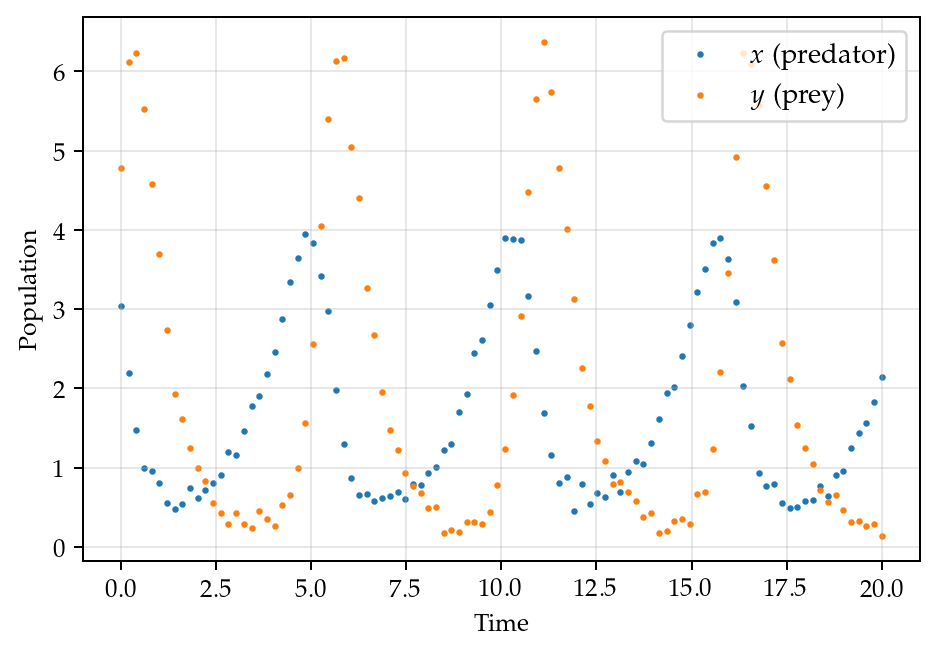

In [14]:
#plt.plot(t, z[0], label="$x$ fit", alpha=0.7)
#plt.plot(t, z[1], label="$y$ fit", alpha=0.7)
plt.scatter(t, P[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(t, P[:,1], s=2.5, label="$y$ (prey)")
plt.ylabel("Population")
plt.xlabel("Time")
plt.legend()
plt.grid(alpha=0.3)
plt.savefig("figures/data_points.pdf", bbox_inches="tight")
plt.show()

# Parameter Tuning

### Cooling schedules visualization

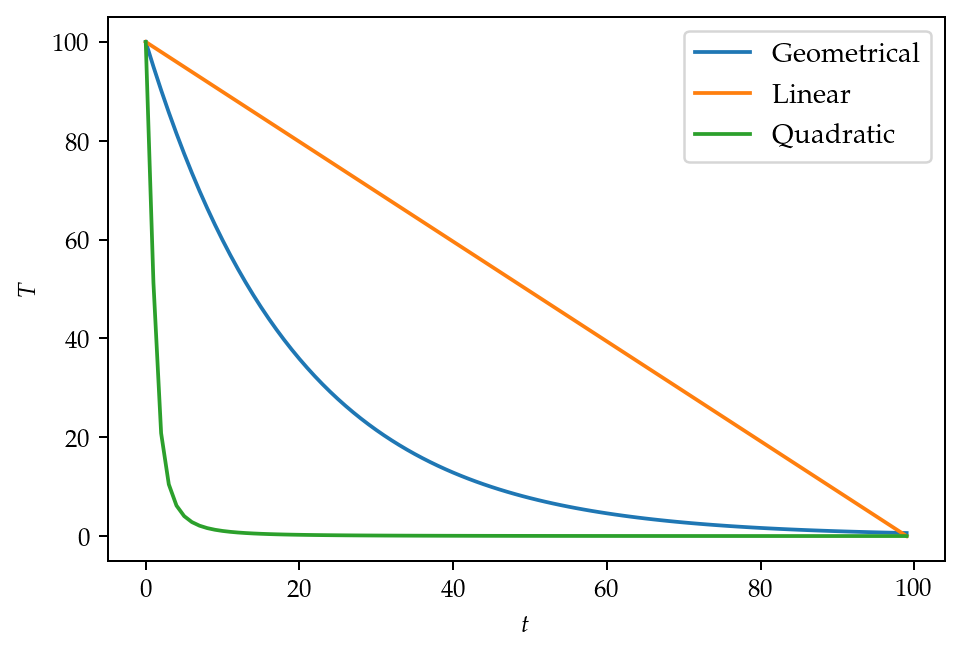

In [26]:
T_start = 100
T_steps = 100
alpha = 0.95

T_sched_geo =  [T_start*alpha**k for k in range(T_steps)]
T_sched_lin = np.linspace(T_start, 1e-5, T_steps)
T_sched_quad = [T_start/(1 + alpha*k**2) for k in range(T_steps)]


plt.plot(T_sched_geo, label="Geometrical")
plt.plot(T_sched_lin, label="Linear")
plt.plot(T_sched_quad, label = "Quadratic")
plt.legend()
plt.ylabel("$T$")
plt.xlabel("$t$")
plt.savefig("figures/cooling_schedules.pdf", bbox_inches="tight")
plt.show()

### Choice Of T0 (start Temperature)

In [27]:
def generate_initial_temperature(Ts, n=20):
    s0s = np.random.uniform(low=0.5, high=4, size=(5, 4))
    ratio_means = []
    ratio_stdevs = []
    
    for T in Ts:
        accepted_ratios = []
        for s0 in s0s:
            for i in range(n):
                _, accepted_ratio = simulated_annealing(s0, t, P, T_start=T, T_steps=200, alpha=1)
                accepted_ratios.append(accepted_ratio)
        ratio_means.append(np.mean(accepted_ratios))
        ratio_stdevs.append(np.std(accepted_ratios))
            
    return np.array(ratio_means), np.array(ratio_stdevs)

In [30]:
if False:
    shelf = shelve.open("Arrays/t0_parameter")
    
    Ts = np.linspace(1, 1000, 20, dtype=int)
    np.random.seed(111)
    ratio_means, ratio_stdevs = generate_initial_temperature(Ts)

    shelf["means"] = ratio_means
    shelf["stdevs"] = ratio_stdevs
    shelf.close()

In [31]:
shelf = shelve.open("Arrays/t0_parameter")
ratio_means, ratio_stdevs = shelf["means"], shelf["stdevs"]
shelf.close()

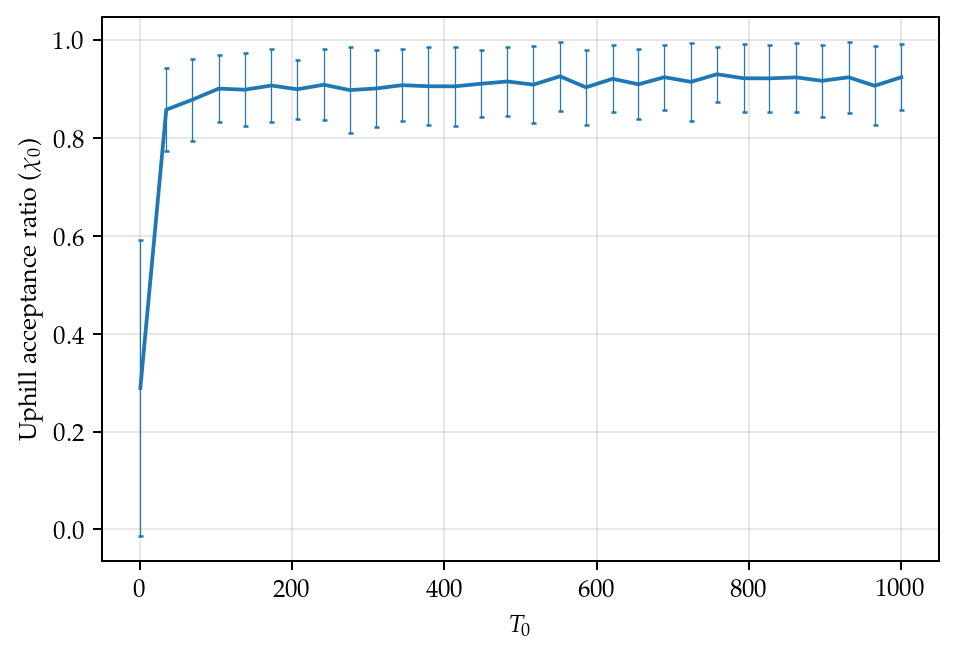

In [60]:
Ts = np.linspace(1, 1000, 30, dtype=int)
#plt.plot(Ts, ratio_means)
plt.errorbar(Ts, ratio_means, yerr=ratio_stdevs, capsize = 1, elinewidth=0.5, markeredgewidth=1)
#plt.ylim(0.5, 1.05)
plt.xlabel("$T_0$")
plt.ylabel("Uphill acceptance ratio ($\\chi_0$)")
plt.grid(alpha=0.3)
plt.savefig("figures/t0_acceptance_ratio.pdf", bbox_inches="tight")
plt.show()

### Choice of T steps (iterations)

In [61]:
def rvs_generator(n_rv = 10):
    return np.random.uniform(low=0.5, high=2, size=(n_rv,4))


def Vary_T_steps(cooling_schedule, rvs, n_sim = 20, T_start = 200):
    T_steps_range = np.linspace(1, 3000, 20, dtype=int) 
    manager = mp.Manager()
    results = manager.list()

    work_queue = mp.Queue()
    for i in range(len(T_steps_range)):
        results.append(manager.list())
        for _ in range(n_sim):
            for rv in rvs:
                work_queue.put((T_steps_range[i], i, rv))

    processes = []

    for i in range(11):
        p = mp.Process(target=vary_T_worker, args=(
            work_queue, results, T_start, t, P, cooling_schedule
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], T_steps_range


In [62]:
np.random.seed(692304)
rvs = rvs_generator(n_rv = 5)

In [63]:
%%time
if False: 
    shelf = shelve.open("Arrays/T_parameter")
    T_vary_geo, T_steps_range = Vary_T_steps(cooling_schedule="geometrical", rvs=rvs)
    shelf["T_vary_geo"] = T_vary_geo
    shelf["T_steps_range"] = T_steps_range
    
    T_vary_lin, _ = Vary_T_steps(cooling_schedule="linear", rvs=rvs)
    shelf["T_vary_lin"] = T_vary_lin
    
    T_vary_quad, _ = Vary_T_steps(cooling_schedule="quadratic", rvs=rvs)
    shelf["T_vary_quad"] = T_vary_quad
    
    shelf.close()

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 6.91 µs


In [64]:
#Open data
shelf = shelve.open("Arrays/T_parameter")
T_vary_geo = shelf["T_vary_geo"] 
T_steps_range = shelf["T_steps_range"] 
T_vary_lin = shelf["T_vary_lin"] 
T_vary_quad = shelf["T_vary_quad"] 
shelf.close() 

In [70]:
def vary_T_steps_plotter(Geo_data, Lin_data, Quad_data, T_steps_range):
    datasets = [Lin_data, Quad_data, Geo_data]
    colors = ["tab:olive", "tab:grey", "tab:pink"]
    for i in range(len(datasets)):
        mean = np.mean(datasets[i], axis = 1)
        min_ = np.min(datasets[i], axis = 1)
        max_ = np.max(datasets[i], axis = 1)
        stdev = np.std(datasets[i], axis = 1, ddof=1)
        a = [sp_confidence_interval(samples) for samples in np.array(datasets[i])]
        plt.plot(T_steps_range, mean, 'o', markersize = 2, linewidth=1, color = colors[i])
        plt.fill_between(T_steps_range, min_, max_, alpha=0.3, color = colors[i])
        plt.errorbar(T_steps_range, mean, yerr=stdev, color = colors[i], capsize = 1, elinewidth=0.5, markeredgewidth=1)
    plt.grid(alpha=0.3)
    plt.ylabel("MSE")
    #plt.xlim(1,5000)
    plt.xlabel("Number of Iterations ($k$)")
    plt.legend(["Linear Schedule", "Quadratic Schedule", "Geometrical Schedule"])
    plt.savefig("figures/Markov_chain_length.pdf", bbox_inches="tight")
    plt.show()         

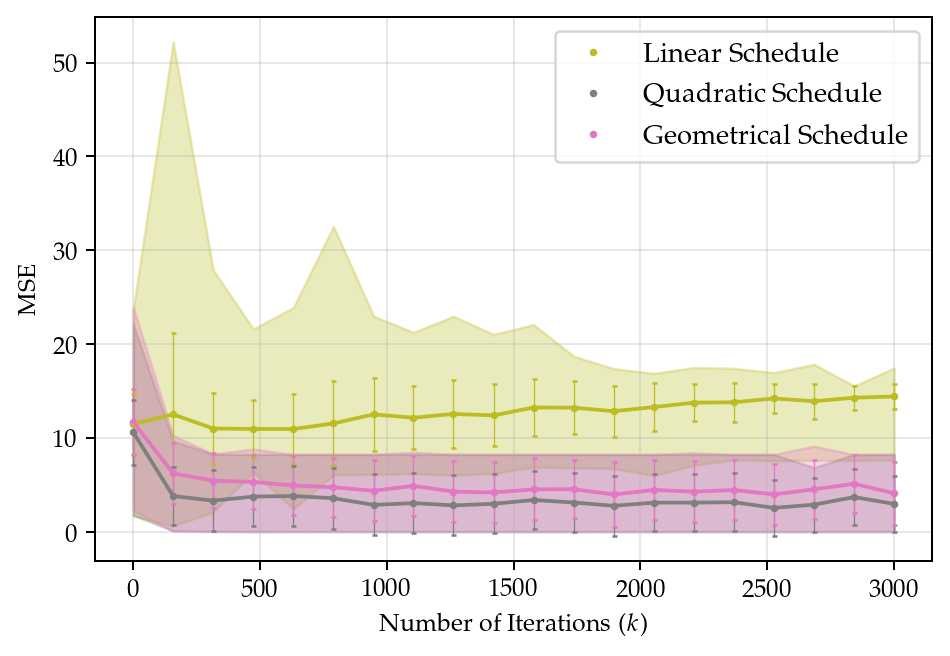

In [71]:
vary_T_steps_plotter(T_vary_geo, T_vary_lin, T_vary_quad, T_steps_range)

### Parameter tuning sigma

In [9]:
def Vary_sigma(rvs, n_sim = 20, T_start = 200, T_steps = 2000, cooling_schedule = "quadratic"):
    sigmas = np.linspace(0.001, 1, 20) 
    manager = mp.Manager()
    results = manager.list()

    work_queue = mp.Queue()
    for i in range(len(sigmas)):
        results.append(manager.list())
        for _ in range(n_sim):
            for rv in rvs:
                work_queue.put((sigmas[i], i, rv))

    processes = []

    for i in range(11):
        p = mp.Process(target=vary_sigma_worker, args=(
            work_queue, results, T_start, T_steps, t, P, cooling_schedule
        ))
        p.daemon = True
        p.start()
        processes.append(p)

    for p in processes:
        p.join()

    return  [list(t) for t in results], sigmas

In [29]:
%%time
np.random.seed(5893)
if False: 
    shelf = shelve.open("Arrays/T_parameter")
    sigmas_MSE, sigmas = Vary_sigma(rvs)
    shelf["sigmas_MSE"] = sigmas_MSE
    shelf["sigmas"] = sigmas  
    shelf.close() 

Wall time: 31min 17s


In [10]:
shelf = shelve.open("Arrays/T_parameter")
sigmas_MSE = shelf["sigmas_MSE"]
sigmas = shelf["sigmas"]   
shelf.close() 

In [69]:
def vary_sigma_plotter(sigmas_MSE, sigmas):

    mean = np.mean(sigmas_MSE, axis = 1)
    min_ = np.min(sigmas_MSE, axis = 1)
    max_ = np.max(sigmas_MSE, axis = 1)
    stdev = np.std(sigmas_MSE, axis = 1, ddof=1)
    plt.errorbar(sigmas, mean, yerr=stdev, capsize = 1, elinewidth=0.5, markeredgewidth=1, color = "tab:grey")   
    plt.plot(sigmas, mean, 'o', markersize = 2, linewidth=1, color = "black", zorder =5)
    plt.grid(alpha=0.3)
    plt.ylabel("MSE")
    plt.xlabel("Neigbour Step Size Scaling Factor ($\eta$)")
    plt.savefig("figures/Buurman_en_Buurman.pdf", bbox_inches="tight")
    plt.show()   

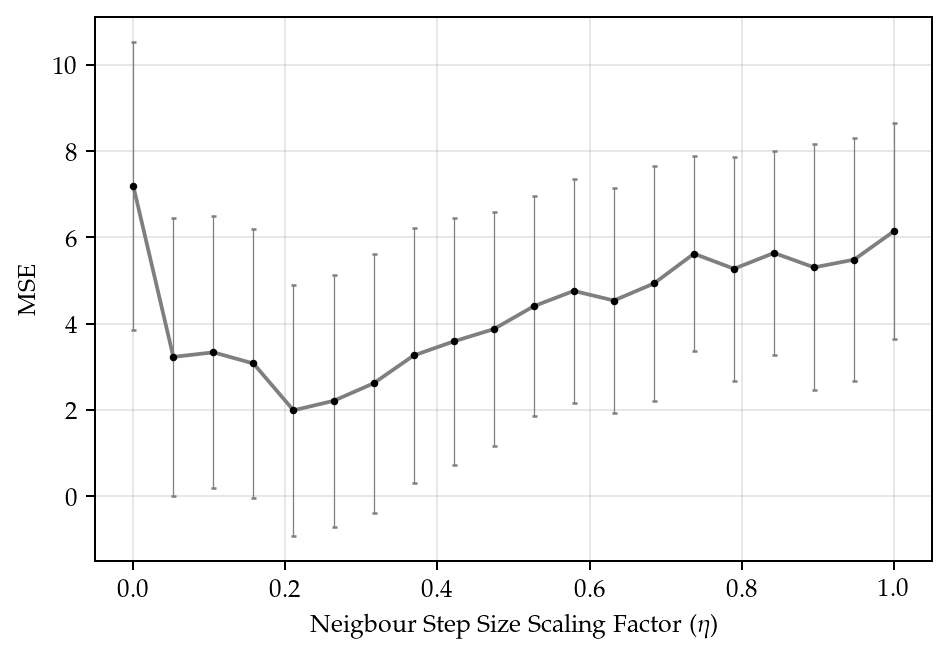

In [68]:
vary_sigma_plotter(sigmas_MSE, sigmas)

# Solution Testing and plotting

In [126]:
#np.random.seed(1212)
s0 = [1, 1, 0.21, 1]
print(int_cost_lotka_volterra(s0, P, t, cost=mse))
x, _, _ = simulated_annealing(s0, t, P, T_start=200, T_steps=5000)

57.42093030482687


In [127]:
print(x)

[0.72611706 0.63052079 0.82271221 0.93630049]


6.31611482131245


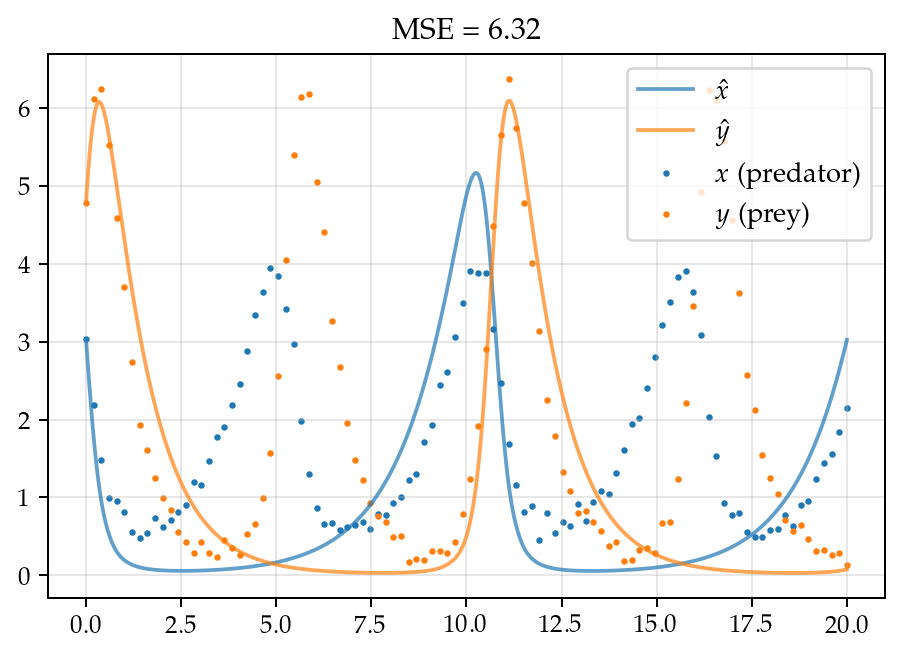

In [128]:
from scipy.integrate import solve_ivp
import numpy as np

sol_opt = solve_ivp(lotka_volterra, (t[0], t[-1]), P[0], args=x, dense_output=True)
z_opt = sol_opt.sol(t)
ts = np.linspace(t[0], t[-1], 500)
z_opt_smooth = sol_opt.sol(ts)

mse_ = mse(P, z_opt.T)
print(mse_)

plt.plot(ts, z_opt_smooth[0], label="$\\hat{x}$", alpha=0.7)
plt.plot(ts, z_opt_smooth[1], label="$\\hat{y}$", alpha=0.7)
plt.scatter(t, P[:,0], s=2.5, label="$x$ (predator)")
plt.scatter(t, P[:,1], s=2.5, label="$y$ (prey)")
plt.title(f"MSE = ${mse_:.2f}$")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

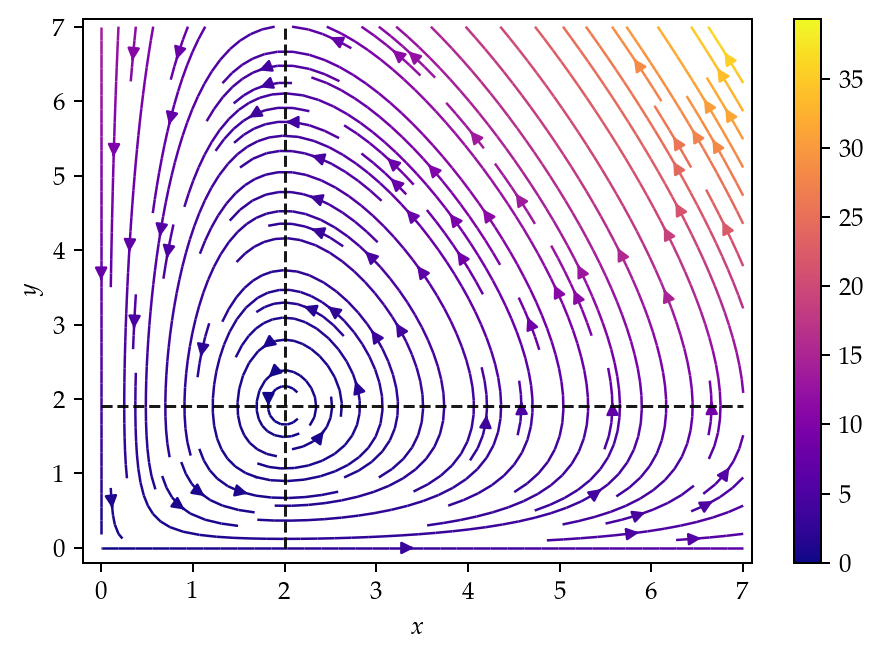

In [118]:
def phase_plot(dx_dt, dy_dt, deriv_params=(), pt_range=(0.001, 0.99), n_pts=50):
    x_pts = np.linspace(pt_range[0], pt_range[1], n_pts)
    y_pts = np.linspace(pt_range[0], pt_range[1], n_pts)

    x, y = np.meshgrid(x_pts, y_pts)
    u, v = np.zeros(x.shape), np.zeros(y.shape)

    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            x_pt = x[i, j]
            y_pt = y[i, j]
            u[i, j] = dx_dt(*deriv_params, x_pt, y_pt)
            v[i, j] = dy_dt(*deriv_params, x_pt, y_pt)

    color_array = np.sqrt(v**2 + u**2)

    return x, y, u, v, color_array

def dx_dt(alpha, beta, _delta, _gamma, x, y):
    return alpha*x - beta*x*y

def dy_dt(_alpha, _beta, delta, gamma, x, y):
    return delta*x*y - gamma*y


params = (0.95, 0.5, 1, 2)

x_steady = params[-1]/params[-2]
y_steady = params[0]/params[1]

x, y, u, v, color_array = phase_plot(dx_dt, dy_dt, deriv_params=params, pt_range=(0, 7), n_pts=200)

plt.figure(figsize=(6, 4))
#plt.quiver(S, I, u2, v2, color_array, cmap='coolwarm', pivot="mid")
plt.streamplot(x, y, u, v, density=1.275, linewidth=1, color=color_array, cmap="plasma")
plt.hlines(y_steady, 0, 7, zorder=5, linewidth=1.2, color="black", linestyles="dashed", alpha=0.9)
plt.vlines(x_steady, 0, 7, zorder=5, linewidth=1.2, color="black", linestyles="dashed", alpha=0.9)
plt.xlabel("$x$")
plt.ylabel("$y$")
plt.xlim(-0.2, 7.1)
plt.ylim(-0.2, 7.1)
plt.colorbar()
plt.savefig("figures/lotka_volterra_phase.pdf", bbox_inches="tight")
plt.show()